In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        '''
        in_planes : 입력 필터개수
        out_planes : 출력 필터개수
        '''
        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치정규화
        
        # 3x3 필터를 사용 (패딩1이므로 이미지가 동일하게 나옴)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # 핵심 부분
        out = F.relu(out)
        return out

In [12]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, num_class=10):
        super(Resnet, self).__init__()
        self.in_planes = 64
        
        # 64개의 3x3필터 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_class)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def Resnet18():
    return Resnet(BasicBlock, [2,2,2,2])

## 데이터셋 로드

In [10]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([ #불러오는 이미지 데이터에 전처리 및 augmentaion을 다양하게 적용할 때 이용하는 메서드
    transforms.RandomCrop(32, padding=4), #잘라낼 크기 설정. 그 크기만큼 랜덤으로 잘라냄
    transforms.RandomHorizontalFlip(), # 해당이미지를 50%의 확률로 좌우반전
    transforms.ToTensor(), #딥러닝 모델의 input으로 이용할 수 있게 이미지 데이터를 tensor형태로 변환 및 0~1로 정규화
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# torchvision dataset의 CIFAR10다운로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 모델에 넣기 위한 데이터 세팅
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2) #num_workers는 dataset의 데이터를 gpu로 전송할 때 필요한 전처리를 수행할 때 사용하는 subprocess의 수
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [01:45<00:00, 1614533.09it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [98]:
train_dataset.data.shape

(50000, 32, 32, 3)

0


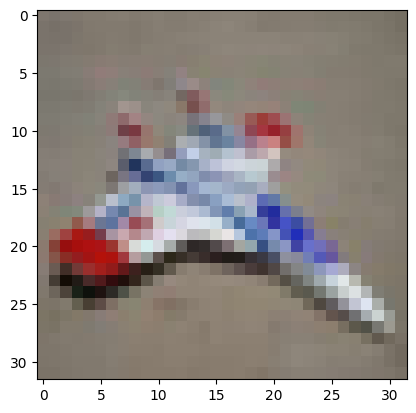

In [101]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset.data[30])
print(train_dataset.targets[30]) # 0 : airplane

In [26]:
data, target = next(iter(train_loader))
data.shape, target.shape
# data : 배치사이즈, 채널, 가로, 세로
# target : label 128개

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [38]:
data[127].shape

torch.Size([3, 32, 32])

In [40]:
target.data

tensor([9, 9, 1, 5, 9, 8, 4, 3, 1, 5, 9, 6, 4, 4, 8, 4, 9, 7, 2, 5, 7, 4, 7, 5,
        7, 2, 6, 8, 5, 8, 4, 0, 8, 2, 0, 3, 6, 6, 3, 2, 0, 2, 4, 0, 5, 0, 1, 1,
        1, 9, 7, 8, 0, 1, 6, 5, 2, 8, 3, 6, 0, 6, 5, 5, 7, 6, 6, 3, 8, 1, 8, 6,
        7, 0, 0, 9, 4, 1, 7, 5, 6, 8, 1, 4, 0, 8, 5, 3, 8, 5, 8, 6, 9, 8, 3, 6,
        9, 8, 2, 6, 5, 9, 7, 9, 4, 0, 3, 4, 3, 6, 1, 6, 4, 0, 3, 0, 2, 0, 5, 7,
        6, 9, 1, 2, 7, 1, 4, 0])

## 환경설정 및 train, test정의

In [9]:
print(f"torch version : {torch.__version__}, cuda is available : {torch.cuda.is_available()}")

torch version : 2.1.2+cu118, cuda is available : True


In [191]:
device = 'cuda'

net = Resnet18()
net = net.to(device)

learning_rate = 0.1
file_name = 'resnet18_cifar10.pth'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002) # weight_decay : 가중치 감소를 통한 가중치 정형화


In [107]:
parameters = list(net.parameters())
for i in range(len(parameters)):
    print(parameters[i].size())

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [157]:
net

Resnet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [192]:
def train(epoch):
    print(f"\n[ Train epoch : {epoch}]")
    net.train() # 모델을 학습모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # image와 target을 장비에 할당
        optimizer.zero_grad() #optimizer gradient 초기화
              
        outputs = net(inputs) #장비에 할당된 이미지를 모델의 input으로 이용해 output을 계산
        #print("output : ", outputs)
        #print("output.shape : ", outputs.shape) #output.shape :  torch.Size([128, 10]) 128개 이미지 각각 class 10에 대한 확률 
        loss = criterion(outputs, targets) # 계산된 output과 target을 criterion(CrossEntropy)를 이용해서 loss 계산
        #print("loss : ", loss) # loss :  tensor(2.38660)
        loss.backward() # loss 계산한 결과를 바탕으로 back propagation을 통해 계산된 gradient값을 각 파라미터에 할당

        optimizer.step() # gradient값을 이용해 파라미터값 업데이트
        train_loss += loss.item() # tensor에 하나의 값만 존재한다면 scalar값을 얻을 수 있음. 만일 여러개 존재한다면 사용 불가.
              
        '''
        for i in range(outputs.size(1)): #10
            print(outputs[i])'''
        # outputs[0] : 첫번째 이미지에 대한 10개의 클래스 중 확률 값. 첫번째 이미지의 label은 9. 
        # tensor([-0.6967,  0.4949, -0.3854,  0.6380,  0.4872, -0.4960, -1.0212,  0.2237, 0.5431, -0.8949], device='cuda:0', grad_fn=<SelectBackward0>)
        '''        
        for j in range(len(outputs.max(1))):
            print("output max :", outputs.max(1))'''
        _, predicted = outputs.max(1) # output의 크기가 배치크기x클래스개수. 최댓값과 최댓값의 위치를 산출. _으로 처리하여 해당 출력값은 저장하지 않고, 최댓값의 위치만 predicted에 저장하겠다.
        # values=tensor([3.3213, 1.3654, 3.1423, 2.0251, 1.9749, 2.1859, 1.1904, 2.1445, 2.3648, ... ] 128개
        # indices=tensor([5, 9, 1, 1, 5, 8, 9, 5, 7, 5, 0, 8, 7, 1, 9, 5, 4, 1, 1, 5, 1, 5, 6, 2, ... ] => predicted. 128개
        
        total += targets.size(0) # 128
        current_correct = predicted.eq(targets).sum().item() # 배열과 targets가 일치하는지 검사하고 sum으로 일치하는 것들의 개수의 합을 숫자로 출력
        correct += current_correct
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch : ', str(batch_idx))
            print(f'Current batch average train accuracy : {current_correct}/{target.size(0)} => {current_correct/target.size(0)}')
            print(f'Current batch average train loss : {loss.item()}/{targets.size(0)} => {loss.item()/targets.size(0)}')
            
    print(f'\nTotal average train accuracy : {correct}/{total} => {correct/total}')
    print(f'Total average train loss : {train_loss}/{total} => {train_loss/total}')
        

In [193]:
def test(epoch):
    print('\n[Test epoch : %d]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0) # 128
        
        outputs = net(inputs)
        loss += criterion(outputs, targets).item()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        
    print('\nTotal average test accuracy : ', correct/total)
    print('Total average test loss : ', loss/total)
    
    state = {
        'net' : net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

## 학습 진행

In [194]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 50:
        lr /=10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
start_time = time.time()

for epoch in range(0,50):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)
    print('\nTime elapsed : ', time.time() - start_time)


[ Train epoch : 0]

Current batch :  0
Current batch average train accuracy : 9/128 => 0.0703125
Current batch average train loss : 2.422952890396118/128 => 0.018929319456219673

Current batch :  100
Current batch average train accuracy : 41/128 => 0.3203125
Current batch average train loss : 1.8995040655136108/128 => 0.014839875511825085

Current batch :  200
Current batch average train accuracy : 46/128 => 0.359375
Current batch average train loss : 1.6757712364196777/128 => 0.013091962784528732

Current batch :  300
Current batch average train accuracy : 45/128 => 0.3515625
Current batch average train loss : 1.7577013969421387/128 => 0.013732042163610458

Total average train accuracy : 15120/50000 => 0.3024
Total average train loss : 751.9228405952454/50000 => 0.015038456811904907

[Test epoch : 0]

Total average test accuracy :  0.4013
Total average test loss :  0.0128086887717247
Model Saved!

Time elapsed :  41.82959461212158

[ Train epoch : 1]

Current batch :  0
Current batch

## 새로운 이미지 검증(test)

In [130]:
from PIL import Image
import cv2

(275, 183)
(32, 32)


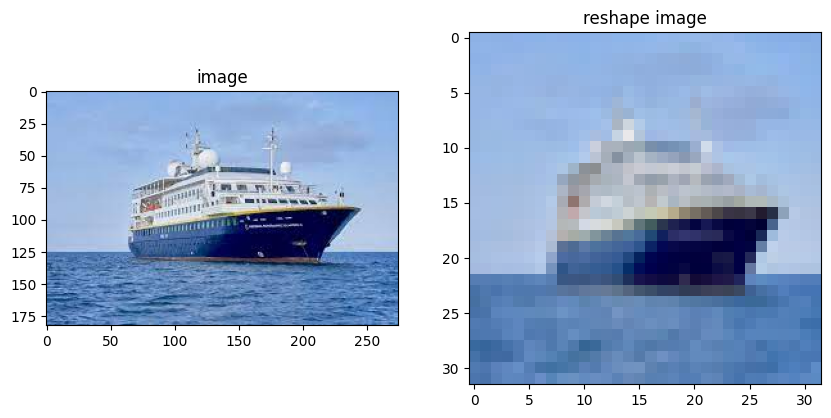

In [234]:
image = Image.open('./ship.jpg')
reshape_image = image.resize((32,32))

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('image')
print(image.size)

plt.subplot(1,2,2)
plt.imshow(reshape_image)
plt.title('reshape image')
print(reshape_image.size)

In [235]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

cat_tensor = transform(reshape_image).unsqueeze(0)

In [186]:
cat_tensor.size()

torch.Size([1, 3, 32, 32])

In [241]:
if torch.cuda.is_available():
    net = net.to('cuda')
    
if torch.cuda.is_available():
    cat_tensor = cat_tensor.to('cuda')

In [237]:
# pretrain 준비
torch.load('./checkpoint/resnet18_cifar10.pth')

{'net': OrderedDict([('conv1.weight',
               tensor([[[[ 1.9007e-02,  7.0236e-02,  7.6553e-02],
                         [ 3.6165e-02,  9.3259e-02,  9.6969e-02],
                         [-2.0013e-02,  1.0872e-02,  5.7526e-02]],
               
                        [[-2.6176e-02,  4.3282e-02,  5.6957e-02],
                         [-2.3329e-02,  3.2779e-02,  6.1962e-02],
                         [-5.4937e-02, -4.2050e-02,  9.0840e-03]],
               
                        [[-4.1336e-02,  1.8785e-02,  3.5406e-02],
                         [-5.0364e-02, -1.3069e-02,  6.8028e-03],
                         [-7.8665e-02, -8.8680e-02, -4.3480e-02]]],
               
               
                       [[[ 6.1746e-02, -2.7466e-02, -1.1448e-01],
                         [-3.0563e-02, -4.4555e-02,  6.4489e-02],
                         [ 6.0118e-03, -5.7901e-02,  4.4292e-02]],
               
                        [[ 8.0762e-02,  2.2446e-02, -3.5991e-02],
                   

In [242]:
pretrained_dict = torch.load('./checkpoint/resnet18_cifar10.pth')
net_dict = net.state_dict()

# 필요한 가중치만 가져오기
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net_dict}

# 선택한 가중치만 불러오기
net_dict.update(pretrained_dict)
net.load_state_dict(net_dict)

<All keys matched successfully>

In [243]:
with torch.no_grad():  # 기울기 계산 비활성화
    output = net(cat_tensor)
    predicted_class = output.argmax(1).item()
    # torch.return_types.max(
    # values=tensor([4.0649], device='cuda:0'),
    # indices=tensor([3], device='cuda:0'))


In [244]:
# 예측된 클래스 확인
print("예측된 클래스:", predicted_class)

예측된 클래스: 8
